In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats.stats import pearsonr
import matplotlib
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('pokemon.csv')
train = pd.get_dummies(data)


In [3]:
X_train = pd.concat([pd.get_dummies(train['hasGender']), train.drop('hasGender', axis=1)], axis=1).drop('isLegendary', axis=1)
X_test = X_train
Y_train = data['isLegendary']

In [4]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

# Missing Data

In [5]:
total = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum() / X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Pr_Male,77,0.106796
Body_Style_with_fins,0,0.000000
Name_Grotle,0,0.000000
Name_Haunter,0,0.000000
Name_Hariyama,0,0.000000


In [6]:
X_train = X_train.drop('Pr_Male', axis=1)

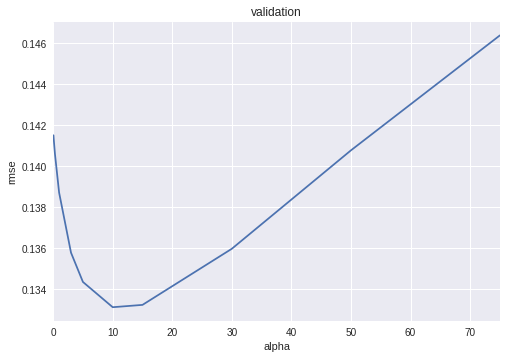

In [8]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='validation');
plt.xlabel('alpha');
plt.ylabel('rmse');
plt.show()

In [7]:
model_ridge = Ridge(alpha=5).fit(X_train, Y_train)
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

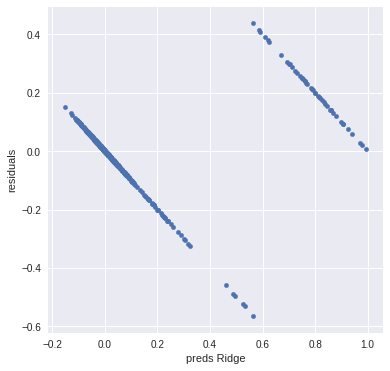

In [10]:
preds_ridge = pd.DataFrame({"preds Ridge":model_ridge.predict(X_train), "true":Y_train})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds Ridge"]
preds_ridge.plot(x = "preds Ridge", y = "residuals", kind = "scatter");
plt.show()

In [14]:
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, Y_train)

In [16]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 29 variables and eliminated the other 795 variables


In [19]:
imp_coef = pd.concat([coef.sort_values().head(5),
                       coef.sort_values().tail(7)])
print imp_coef

Egg_Group_1_Mineral           -0.124535
Body_Style_bipedal_tailless   -0.017392
Type_2_Psychic                -0.016900
Type_2_Steel                  -0.016298
Egg_Group_1_Flying            -0.012527
Egg_Group_1_Bug                0.010729
Body_Style_head_arms           0.012023
Color_Brown                    0.016239
Type_1_Dragon                  0.040316
Body_Style_two_wings           0.043311
False                          0.229167
Egg_Group_1_Undiscovered       0.411670
dtype: float64


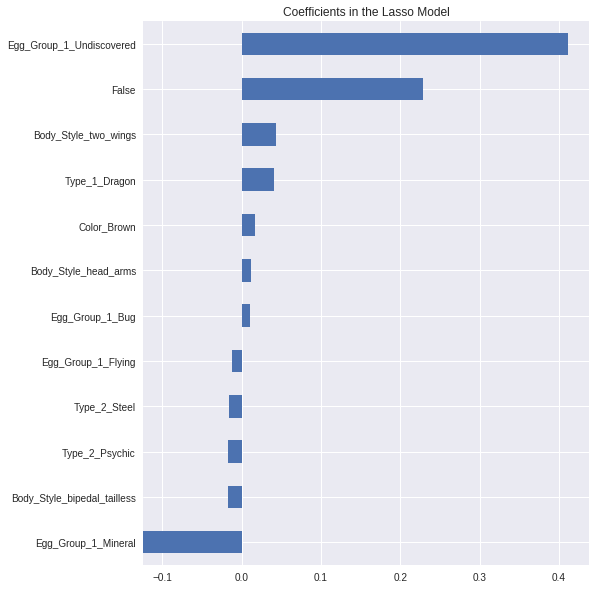

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0);
imp_coef.plot(kind = "barh");
plt.title("Coefficients in the Lasso Model")
plt.show()

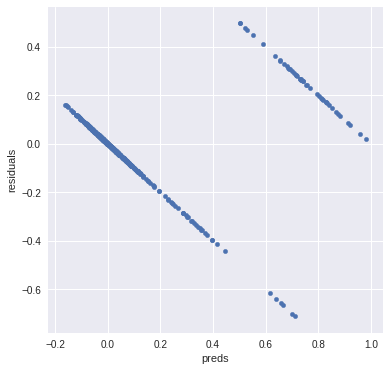

In [22]:
# let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter");

plt.show()

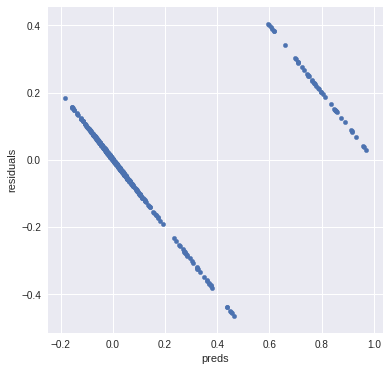

In [23]:
model_elas = ElasticNet(alpha=0.001, l1_ratio=0.5, fit_intercept=True, normalize=False, 
             precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False,
             positive=False, random_state=None, selection='cyclic').fit(X_train, Y_train)
preds = pd.DataFrame({"preds":model_elas.predict(X_train), "true":Y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter");

plt.show()

In [27]:
dtrain = xgb.DMatrix(X_train, label = Y_train)
dtest = xgb.DMatrix(X_test)
params = {"max_depth":6, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

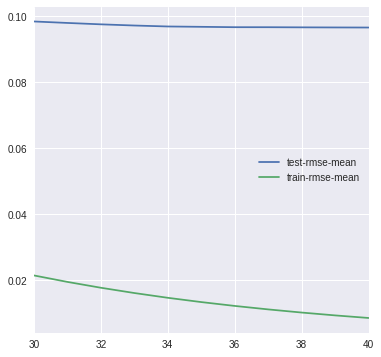

In [33]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot();
plt.show()

In [45]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=6, learning_rate=0.1)
model_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

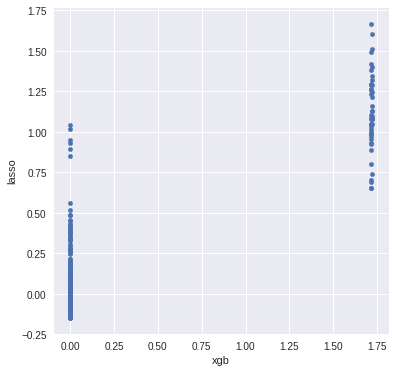

In [51]:
X_test = X_train
lasso_preds = np.expm1(model_lasso.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
xgb_preds = np.expm1(model_xgb.predict(X_test))
elas_preds = np.expm1(model_elas.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter");
plt.show()